In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
from LQN_utils_state_save_parallel import *
import itertools
from copy import deepcopy 
import sympy as sp
from itertools import groupby

In [2]:
import hashlib

일단은 ChatGPT 예제는 잘 작도암. 우리가 사용하는 그래프에 대해서 확인해보기

아래 부분부터 잘되는거 시작. 위 코드들은 다시 weighted bigraph의 canonical form을 구하기 위해서 다양한 시도를 하는 부분

In [33]:
import networkx as nx
import igraph as ig
import itertools
import hashlib

def EPM_bipartite_graph_generator(num_system, num_ancilla, type): 
    num_total = num_system + num_ancilla

    # red-blue 조합 생성 (type=0 가정)
    red_blue_combinations, num_combi = list_all_combinations_with_duplication(num_system, num_ancilla)

    # ancilla 조합 생성
    ancilla_combinations_pre = generate_combinations(num_total)
    ancilla_combinations = list(itertools.product(ancilla_combinations_pre, repeat=num_ancilla))

    for rb_comb in red_blue_combinations:
        if num_ancilla != 0:
            for bl_comb in ancilla_combinations:
                B = nx.Graph()
                B.add_nodes_from(range(2 * num_total))
                mapping = {}

                # red-blue 엣지 추가
                for rb_index, vt in enumerate(rb_comb):
                    red = num_total + vt[0]
                    blue = num_total + vt[1]
                    B.add_edge(rb_index, red, weight=1.0)
                    B.add_edge(rb_index, blue, weight=2.0)
                    mapping[rb_index] = 'S_' + str(rb_index)
                    mapping[num_total + rb_index] = rb_index

                # ancilla 엣지 추가
                for anc_index, vt_list in enumerate(bl_comb):
                    for vt_inx in vt_list:
                        B.add_edge(num_system + anc_index, num_total + vt_inx, weight=3) 
                    mapping[num_system + anc_index] = 'A_' + str(anc_index)
                    mapping[num_total + num_system + anc_index] = num_system + anc_index

                # ✅ 노드 속성 추가
                for node_index in range(2 * num_total):
                    if node_index < num_system:
                        B.nodes[node_index]['category'] = 'system_nodes'
                        B.nodes[node_index]['bipartite'] = 0
                    elif node_index < num_total:
                        B.nodes[node_index]['category'] = 'ancilla_nodes'
                        B.nodes[node_index]['bipartite'] = 0
                    else:
                        B.nodes[node_index]['category'] = 'sculpting_nodes'
                        B.nodes[node_index]['bipartite'] = 1

                # ✅ 속성이 유지되도록 `copy=False` 사용
                B = nx.relabel_nodes(B, mapping, copy=False)

                # ✅ 속성 재적용 (relabel_nodes 이후 속성이 사라질 경우 대비)
                for old_node, new_node in mapping.items():
                    if new_node in B.nodes:
                        B.nodes[new_node]['category'] = B.nodes.get(old_node, {}).get('category', 'unknown')
                        B.nodes[new_node]['bipartite'] = B.nodes.get(old_node, {}).get('bipartite', -1)

                if all(len(list(B.neighbors(node))) >= 2 for node in B.nodes):
                    yield B  # ✅ 제너레이터 사용

# NetworkX -> iGraph 변환
def nx_to_igraph(nx_graph):
    # 노드 매핑 (문자열 → 정수 변환)
    node_map = {node: idx for idx, node in enumerate(nx_graph.nodes)}

    # 엣지 추출
    edges = []
    for u, v in nx_graph.edges():
        edges.append((node_map[u], node_map[v]))  # 정수 인덱스로 변환된 엣지 추가

    # iGraph 객체 생성
    ig_graph = ig.Graph()
    ig_graph.add_vertices(len(node_map))  # 노드 추가
    ig_graph.add_edges(edges)  # 엣지 추가
    return ig_graph

import hashlib

def canonical_form_without_weights(ig_graph):
    perm = ig_graph.canonical_permutation()
    permuted = ig_graph.permute_vertices(perm)
    return tuple(map(tuple, permuted.get_adjacency().data))

def generate_hash_from_canonical_form(canonical_form):
    canonical_str = str(canonical_form)
    return hashlib.sha256(canonical_str.encode('utf-8')).hexdigest()


def process_and_group_by_canonical_form(graph_iter):
    canonical_groups = defaultdict(list)
    for graph in graph_iter:
        ig_graph = nx_to_igraph(graph)
        canonical_form = canonical_form_without_weights(ig_graph)
        canonical_hash = generate_hash_from_canonical_form(canonical_form)

        if canonical_hash not in canonical_groups:
            def graph_generator():
                yield graph  # ✅ 제너레이터 사용
            canonical_groups[canonical_hash] = graph_generator()

    return canonical_groups  # ✅ 제너레이터 유지

In [34]:
def is_single_scc(graph):
    sccs = list(nx.strongly_connected_components(graph))
    is_scc = len(sccs) == 1 and len(sccs[0]) == len(graph)
    print(f"Graph {graph}: is_single_scc = {is_scc}")  # ❗ 디버깅 추가
    return is_scc


def filter_groups_by_scc(grouped_graphs):
    filtered_groups = {}
    removed_count = 0  # ❗ 필터링된 그래프 개수 확인용

    for key, graph_gen in grouped_graphs.items():
        try:
            first_graph = next(graph_gen)  # ✅ 제너레이터에서 첫 번째 그래프 가져오기
            D = EPM_digraph_from_EPM_bipartite_graph(first_graph)  # ✅ 정상 작동!
            if is_single_scc(D):
                filtered_groups[key] = graph_gen  # ✅ 제너레이터 유지
            else:
                removed_count += 1
        except StopIteration:
            continue  # ✅ 빈 제너레이터 처리

    print(f"❗ {removed_count}개의 그룹이 SCC 필터링에서 제거됨.")
    return filtered_groups


In [35]:
def get_adjacency_matrices(B):
    system_nodes = [node for node in B.nodes if B.nodes[node]['category'] == 'system_nodes']
    ancilla_nodes = [node for node in B.nodes if B.nodes[node]['category'] == 'ancilla_nodes']
    sculpting_nodes = [node for node in B.nodes if B.nodes[node]['category'] == 'sculpting_nodes']
    int_nodes = [node for node in B.nodes if isinstance(node, int)]  # ✅ int 타입 노드 추가

    # ✅ 모든 노드를 포함하는 정렬
    sorted_nodes = system_nodes + ancilla_nodes + sculpting_nodes + int_nodes

    # ✅ 디버깅 출력
    print(f"Sorted Nodes: {sorted_nodes}")

    weighted_adj_matrix = nx.to_numpy_array(B, nodelist=sorted_nodes, weight='weight')

    print(f"Adjacency Matrix Shape: {weighted_adj_matrix.shape}")
    print(f"Adjacency Matrix: \n{weighted_adj_matrix}")

    return weighted_adj_matrix, sorted_nodes  # ✅ sorted_nodes도 반환하도록 수정


In [36]:
import numpy as np

def EPM_digraph_from_EPM_bipartite_graph(B):
    print(f"Before Conversion: Nodes = {B.nodes(data=True)}, Edges = {list(B.edges(data=True))}")  

    D = nx.DiGraph()

    system_nodes = [node for node in B.nodes if B.nodes[node].get('category', 'unknown') == 'system_nodes']
    ancilla_nodes = [node for node in B.nodes if B.nodes[node].get('category', 'unknown') == 'ancilla_nodes']
    num_system = len(system_nodes)
    num_ancilla = len(ancilla_nodes)
    num_total = num_system + num_ancilla

    # ✅ get_adjacency_matrices()에서 정렬된 노드 리스트 반환
    adj_weight_matrix_B, sorted_nodes = get_adjacency_matrices(B)

    print(f"Adjacency Matrix Shape: {adj_weight_matrix_B.shape}")  
    print(f"num_total: {num_total}, len(sorted_nodes): {len(sorted_nodes)}")

    # ✅ 서브매트릭스 크기 조정
    if num_total > len(sorted_nodes):
        print(f"❌ ERROR: num_total({num_total}) is larger than sorted_nodes size ({len(sorted_nodes)})")
        return D

    # ✅ 적절한 부분 행렬을 추출
    adj_weight_matrix_D = adj_weight_matrix_B[num_total:, :num_total]  # ✅ 슬라이싱 방식 변경
    print(f"Extracted Submatrix Shape: {adj_weight_matrix_D.shape}")
    print(f"Extracted Submatrix: \n{adj_weight_matrix_D}")

    # ✅ 엣지 추가
    for i in range(adj_weight_matrix_D.shape[0]):
        for j in range(adj_weight_matrix_D.shape[1]):
            if adj_weight_matrix_D[i, j] != 0:
                D.add_edge(sorted_nodes[j], sorted_nodes[i + num_total], weight=adj_weight_matrix_D[i, j])  # ✅ 원래 노드 ID 사용
                print(f"✅ Added Edge: {sorted_nodes[j]} → {sorted_nodes[i + num_total]} (weight={adj_weight_matrix_D[i, j]})")

    print(f"After Conversion: Nodes = {D.nodes(data=True)}, Edges = {list(D.edges(data=True))}")

    return D




In [37]:
def extract_unique_bigraphs_with_weights(filtered_groups):
    unique_graphs_list = {}
    edge_match = lambda x, y: x.get("weight", 1) == y.get("weight", 1)

    for key, graph_gen in filtered_groups.items():
        graph_list = list(graph_gen)  # ✅ 제너레이터를 리스트로 변환
        unique_graphs = []

        for new_graph in graph_list:
            is_unique = True
            for existing_graph in unique_graphs:
                if nx.is_isomorphic(new_graph, existing_graph, edge_match=edge_match):
                    is_unique = False
                    break

            if is_unique:
                unique_graphs.append(new_graph)

        unique_graphs_list[key] = unique_graphs  

    return unique_graphs_list  


In [38]:
# 1️⃣ 제너레이터 기반으로 그래프 생성
graph_generator = EPM_bipartite_graph_generator(num_system=3, num_ancilla=1, type=0)

# 2️⃣ canonical form을 기반으로 그룹화 (제너레이터 유지)
grouped_graphs = process_and_group_by_canonical_form(graph_generator)

# # 3️⃣ SCC 조건을 만족하는 그래프만 필터링 (제너레이터 유지)
# filtered_groups = filter_groups_by_scc(grouped_graphs)

# # 4️⃣ 중복 제거
# unique_graphs_list = extract_unique_bigraphs_with_weights(filtered_groups)

# # 5️⃣ 최종 결과 출력
# for key, unique_graphs in unique_graphs_list.items():
#     print(f"Canonical Hash: {key}, Unique Graph Count: {len(unique_graphs)}")


In [43]:
grouped_graphs[list(grouped_graphs.keys())[0]]

<generator object process_and_group_by_canonical_form.<locals>.graph_generator at 0x7f3306c907b0>

In [45]:
first_graph = next(grouped_graphs[list(grouped_graphs.keys())[0]]) 

In [48]:
print(first_graph)

Graph with 8 nodes and 10 edges


NetworkXError: Node 3 has no position.

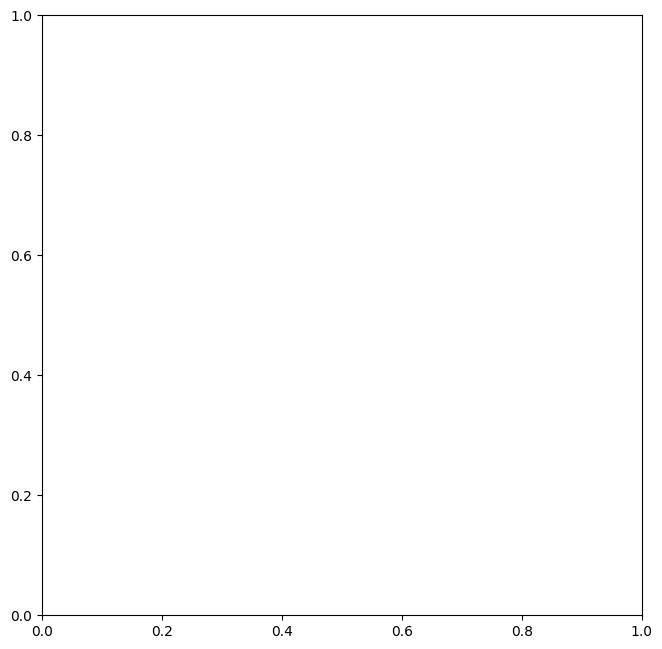

In [51]:
Draw_EPM_bipartite_graph(first_graph)

In [29]:
unique_graphs_list

{}

In [19]:
graph_generator = EPM_bipartite_graph_generator(num_system=3, num_ancilla=1, type=0)

# 생성된 그래프 확인
for i, graph in enumerate(graph_generator):
    print(f"Generated Graph {i}: Nodes = {graph.nodes(data=True)}, Edges = {list(graph.edges(data=True))}")
    if i == 5:  # 5개까지만 출력 (너무 많으면 출력이 부담될 수 있음)
        break


Generated Graph 0: Nodes = [('S_0', {'category': 'system_nodes', 'bipartite': 0}), ('S_1', {'category': 'system_nodes', 'bipartite': 0}), ('S_2', {'category': 'system_nodes', 'bipartite': 0}), ('A_0', {'category': 'ancilla_nodes', 'bipartite': 0}), (0, {'category': 'sculpting_nodes', 'bipartite': 1}), (1, {'category': 'sculpting_nodes', 'bipartite': 1}), (2, {'category': 'sculpting_nodes', 'bipartite': 1}), (3, {'category': 'sculpting_nodes', 'bipartite': 1})], Edges = [('S_0', 0, {'weight': 1.0}), ('S_0', 1, {'weight': 2.0}), ('S_1', 0, {'weight': 1.0}), ('S_1', 1, {'weight': 2.0}), ('S_2', 2, {'weight': 1.0}), ('S_2', 3, {'weight': 2.0}), ('A_0', 2, {'weight': 3}), ('A_0', 3, {'weight': 3})]
Generated Graph 1: Nodes = [('S_0', {'category': 'system_nodes', 'bipartite': 0}), ('S_1', {'category': 'system_nodes', 'bipartite': 0}), ('S_2', {'category': 'system_nodes', 'bipartite': 0}), ('A_0', {'category': 'ancilla_nodes', 'bipartite': 0}), (0, {'category': 'sculpting_nodes', 'bipartite':

In [65]:
len(filtered_groups)

8

In [16]:
len(grouped_graphs)

136

In [7]:
def EPM_digraph_from_EPM_bipartite_graph(B):
    """
    Convert an EPM bipartite graph (B) to a directed graph (D).

    Parameters:
        B (nx.Graph): Input bipartite graph.

    Returns:
        nx.DiGraph: Directed graph derived from the input bipartite graph.
    """
    # Initialize directed graph
    D = nx.DiGraph()

    # Identify system and ancilla nodes
    system_nodes = [node for node in B.nodes if B.nodes[node]['category'] == 'system_nodes']
    ancilla_nodes = [node for node in B.nodes if B.nodes[node]['category'] == 'ancilla_nodes']
    num_system = len(system_nodes)
    num_ancilla = len(ancilla_nodes)
    num_total = num_system + num_ancilla

    # Generate adjacency matrix and weight matrix from B
    adj_weight_matrix_B = get_adjacency_matrices(B)

    # Extract relevant submatrices for the directed graph
    # adj_matrix_D = adj_matrix_B[:num_total, num_total:]
    adj_weight_matrix_D = adj_weight_matrix_B[:num_total, num_total:]

    # Add nodes to directed graph
    D.add_nodes_from(range(num_total))

    # Add directed edges with weights
    for i in range(num_total):
        for j in range(num_total):
            if adj_weight_matrix_D[i, j] != 0:
                D.add_edge(j, i, weight=adj_weight_matrix_D[i, j])  # Reverse direction

    # Map node labels and categories
    mapping = {}
    for i in range(num_total):
        if i < num_system:
            mapping[i] = 'S_' + str(i)
            D.nodes[i]['category'] = 'system_nodes'
        else:
            mapping[i] = 'A_' + str(i - num_system)
            D.nodes[i]['category'] = 'ancilla_nodes'

    # Relabel nodes
    D = nx.relabel_nodes(D, mapping)

    return D


## 위 코드들은 잘 작동함

In [8]:
def is_single_scc(graph):
    """
    Check if the graph is a single strongly connected component (SCC).

    Parameters:
        graph (nx.DiGraph): Directed graph.

    Returns:
        bool: True if the graph is a single SCC, False otherwise.
    """
    sccs = list(nx.strongly_connected_components(graph))
    return len(sccs) == 1 and len(sccs[0]) == len(graph)

# def filter_groups_by_scc(grouped_graphs):
#     """
#     Filter groups of graphs based on whether their first element's DiGraph is a single SCC.

#     Parameters:
#         grouped_graphs (dict): Dictionary where each key represents a group identifier, and the value is a list of graphs.

#     Returns:
#         dict: Filtered dictionary containing only groups whose first graph is a single SCC.
#     """
#     filtered_groups = {}
#     for key, group in grouped_graphs.items():
#         if group:
#             # Convert the first graph in the group to a DiGraph
#             D = EPM_digraph_from_EPM_bipartite_graph(group[0])
#             # Check if it is a single SCC
#             if is_single_scc(D):
#                 filtered_groups[key] = group
#     return filtered_groups

def filter_groups_by_scc(grouped_graphs):
    """
    Filter groups of graphs based on whether their first element's DiGraph is a single SCC.

    Parameters:
        grouped_graphs (dict): Dictionary where each key represents a group identifier, 
                               and the value is a generator of graphs.

    Returns:
        dict: Filtered dictionary containing only groups whose first graph is a single SCC.
    """
    filtered_groups = {}

    for key, graph_gen in grouped_graphs.items():
        try:
            first_graph = next(graph_gen)  # ✅ 제너레이터에서 첫 번째 그래프 가져오기
            D = EPM_digraph_from_EPM_bipartite_graph(first_graph)  # ✅ 정상 동작!
            if is_single_scc(D):
                filtered_groups[key] = graph_gen  # ✅ 제너레이터 유지
        except StopIteration:
            continue  # ✅ 제너레이터가 비어있을 경우 처리

    return filtered_groups


In [32]:
filtered_groups = filter_groups_by_scc(grouped_graphs)

In [33]:
len(filtered_groups)

78

In [34]:
def count_dict_elements(d):
    """
    Count the total number of elements in a dictionary, including keys and values.

    Parameters:
        d (dict): Input dictionary.

    Returns:
        int: Total number of elements in the dictionary.
    """
    if not isinstance(d, dict):
        raise ValueError("Input must be a dictionary.")
    
    total_elements = 0
    
    for key, value in d.items():
        total_elements += 1  # Count the key
        if isinstance(value, (list, dict)):  # Recursively count elements in lists or dictionaries
            total_elements += count_dict_elements(value) if isinstance(value, dict) else len(value)
        else:
            total_elements += 1  # Count the value if not a container
    
    return total_elements


In [35]:
count_dict_elements(filtered_groups)

819918

In [36]:
list(filtered_groups.keys())[0]

'5412046da0c318a980c7edbc89a98ed62e7a3dc5f8b6c5a9edfd6f9656609844'

In [37]:
len(filtered_groups[list(filtered_groups.keys())[0]])

1920

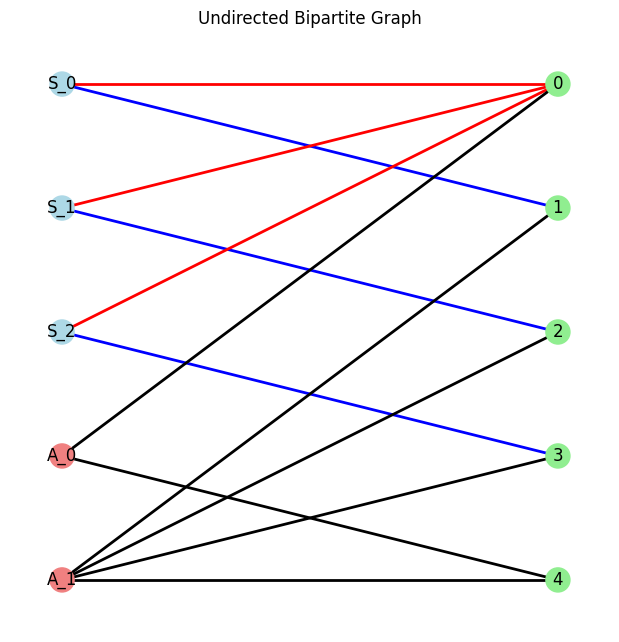

In [38]:
Draw_EPM_bipartite_graph(filtered_groups[list(filtered_groups.keys())[0]][0])

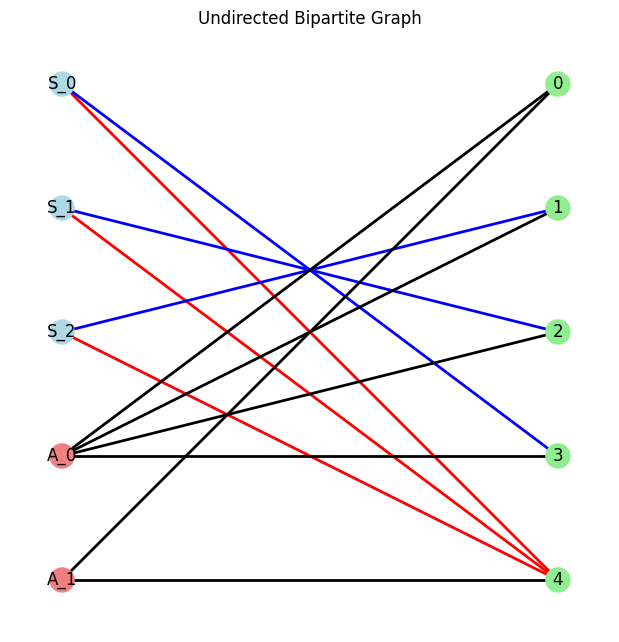

In [39]:
Draw_EPM_bipartite_graph(filtered_groups[list(filtered_groups.keys())[0]][1919])

In [40]:
filtered_groups

{'5412046da0c318a980c7edbc89a98ed62e7a3dc5f8b6c5a9edfd6f9656609844': [<networkx.classes.graph.Graph at 0x7f1e649c6440>,
  ...],
 '9a98a0100458abb4267e3e9c0d724799f7920693c9318f425aebea6789339b59': [<networkx.classes.graph.Graph at 0x7f1e649c5ab0>,
  ...],
 '22698ea5a87cccad8ec04918ae76b00be7c4e1ab28820bfd29a9bbc5d13ea8af': [<networkx.classes.graph.Graph at 0x7f1e649c6ef0>,
  ...],
 '1f911f527de5d2bf3ab5f4e2a3ca1c9653df2adf8c53112a3b9437276a6e4916': [<networkx.classes.graph.Graph at 0x7f1e648cc5b0>,
  ...],
 '7d529fc2fb04c765eecdb1de9779eac0d8111f753df47a2788ee5113679c2782': [<networkx.classes.graph.Graph at 0x7f1e649c4dc0>,
  ...],
 '03c7aa5b9de7b327da92ef0397235030676d9e0dbb6c1f951966882a70bbf963': [<networkx.classes.graph.Graph at 0x7f1e649c5870>,
  ...],
 '2d0ad4361fc9520493fbee367c6150c6a5f92c664fad77050ddec114cbf4430f': [<networkx.classes.graph.Graph at 0x7f1e649c4130>,
  ...],
 'd6d64899958ccdaab33e97e94b9db5ef7a331f098da328fab2b546fca1322252': [<networkx.classes.graph.Graph at 0

In [13]:
import networkx as nx

# def extract_unique_bigraphs_with_weights(graph_list):
#     """
#     Extract unique bipartite graphs from a list, considering edge weights for isomorphism.

#     Parameters:
#         graph_list (list of nx.Graph): A list of bipartite graphs to process.

#     Returns:
#         list of nx.Graph: A list of unique bipartite graphs.
#     """
#     # List to store unique graphs
#     unique_graphs = []

#     # Define edge_match to compare edge weights
#     edge_match = lambda x, y: x.get("weight", 1) == y.get("weight", 1)
    
#     for new_graph in graph_list:
#         # Check if the new graph is isomorphic to any existing unique graph
#         is_unique = True
#         for existing_graph in unique_graphs:
#             if nx.is_isomorphic(new_graph, existing_graph, edge_match=edge_match):
#                 is_unique = False
#                 break

#         # If unique, add to the unique_graphs list
#         if is_unique:
#             unique_graphs.append(new_graph)

#     return unique_graphs

def extract_unique_bigraphs_with_weights(filtered_groups):
    """
    Extract unique bipartite graphs from filtered_groups while considering edge weights.

    Parameters:
        filtered_groups (dict): A dictionary where values are graph generators.

    Returns:
        dict: A dictionary where keys are canonical hashes, and values are lists of unique graphs.
    """
    unique_graphs_list = {}
    edge_match = lambda x, y: x.get("weight", 1) == y.get("weight", 1)

    for key, graph_gen in filtered_groups.items():
        graph_list = list(graph_gen)  # ✅ 제너레이터를 리스트로 변환
        unique_graphs = []

        for new_graph in graph_list:
            is_unique = True
            for existing_graph in unique_graphs:
                if nx.is_isomorphic(new_graph, existing_graph, edge_match=edge_match):
                    is_unique = False
                    break

            if is_unique:
                unique_graphs.append(new_graph)

        unique_graphs_list[key] = unique_graphs  

    return unique_graphs_list  


In [42]:
unique_graphs_list = {}

for filter_keys in filtered_groups.keys():
    unique_graphs_list[filter_keys] = extract_unique_bigraphs_with_weights(filtered_groups[filter_keys])
        

In [43]:
unique_graphs_list

{'5412046da0c318a980c7edbc89a98ed62e7a3dc5f8b6c5a9edfd6f9656609844': [<networkx.classes.graph.Graph at 0x7f1e649c6440>,
 '9a98a0100458abb4267e3e9c0d724799f7920693c9318f425aebea6789339b59': [<networkx.classes.graph.Graph at 0x7f1e649c5ab0>,
 '22698ea5a87cccad8ec04918ae76b00be7c4e1ab28820bfd29a9bbc5d13ea8af': [<networkx.classes.graph.Graph at 0x7f1e649c6ef0>,
 '1f911f527de5d2bf3ab5f4e2a3ca1c9653df2adf8c53112a3b9437276a6e4916': [<networkx.classes.graph.Graph at 0x7f1e648cc5b0>,
 '7d529fc2fb04c765eecdb1de9779eac0d8111f753df47a2788ee5113679c2782': [<networkx.classes.graph.Graph at 0x7f1e649c4dc0>,
 '03c7aa5b9de7b327da92ef0397235030676d9e0dbb6c1f951966882a70bbf963': [<networkx.classes.graph.Graph at 0x7f1e649c5870>,
 '2d0ad4361fc9520493fbee367c6150c6a5f92c664fad77050ddec114cbf4430f': [<networkx.classes.graph.Graph at 0x7f1e649c4130>,
 'd6d64899958ccdaab33e97e94b9db5ef7a331f098da328fab2b546fca1322252': [<networkx.classes.graph.Graph at 0x7f1e649c5450>,
 '462053cef68219cc3b9878afd6c20575c9fb99

In [44]:
count_dict_elements(unique_graphs_list)

733

In [45]:
unique_graphs_list[list(unique_graphs_list.keys())[0]]

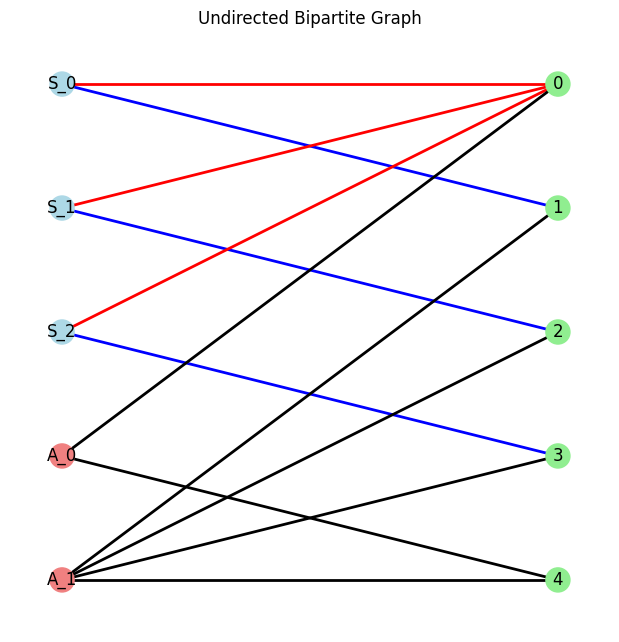

In [46]:
Draw_EPM_bipartite_graph(unique_graphs_list[list(unique_graphs_list.keys())[0]][0])

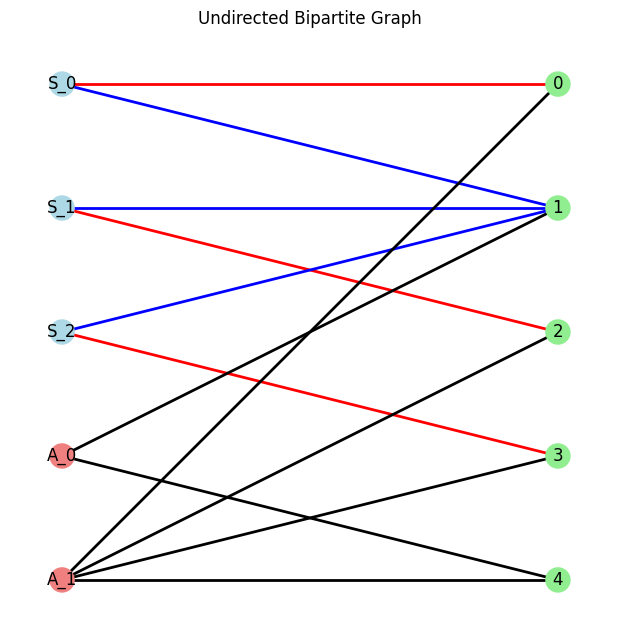

In [79]:
Draw_EPM_bipartite_graph(unique_graphs_list[list(unique_graphs_list.keys())[0]][3])

In [82]:
j = 0
for i in unique_graphs_list[list(unique_graphs_list.keys())[0]]:
    edge_match = lambda x, y: x.get("weight", 1) == y.get("weight", 1)
    if nx.is_isomorphic(filtered_groups[list(filtered_groups.keys())[0]][1919], i, edge_match=edge_match):
        print(j)
    j += 1


0


In [47]:
nx.is_isomorphic(filtered_groups[list(filtered_groups.keys())[0]][1919], unique_graphs_list[list(unique_graphs_list.keys())[0]][0], edge_match=edge_match)

NameError: name 'edge_match' is not defined

In [49]:
def get_key_with_most_elements(input_dict):
    """
    Find the key with the most elements in its value and the number of elements.

    Parameters:
        input_dict (dict): A dictionary where values are iterable.

    Returns:
        tuple: A tuple containing the key with the most elements and the number of elements.
    """
    if not input_dict:
        return None, 0  # Return None if the dictionary is empty

    # Find the key with the most elements
    max_key = max(input_dict, key=lambda k: len(input_dict[k]))
    max_count = len(input_dict[max_key])

    return max_key, max_count


In [50]:
max_key, max_count = get_key_with_most_elements(unique_graphs_list)

In [51]:
max_count

40

In [53]:
max_key

'0e430645aaafb825e08503c3ba53d438108f021b0f53a3196b5a1b185c5a1683'

In [54]:
max_key_fil, max_count_fil = get_key_with_most_elements(filtered_groups)

In [55]:
max_count_fil

57600

In [56]:
max_key_group, max_count_group = get_key_with_most_elements(grouped_graphs)

In [57]:
max_count_group

57600

In [58]:
max_key_group

'0e430645aaafb825e08503c3ba53d438108f021b0f53a3196b5a1b185c5a1683'